# Precision vs. Recall

Before we can dive into the terms of precision and recall we need to recall (no pun intended) the terms error of Type I and error of Type II.

A Type I error would be a false positive. For example we assume something that is wrong, like providing your bank details to a scammer because he told you you won the lottery.  
A Type II error would be a false negative. Assuming something is wrong, although everything is fine, like dropping the call although you actually won the lottery.

## Precision and Recall
According to the definitions of error Type I and Type II the
Precision is given by
$$
P = \frac{\text{true positives}}{\text{actual results}} = \frac{\text{true positives}}{\text{true positives + false positives}},
$$
the Recall given by
$$
R = \frac{\text{true positives}}{\text{predicted results}} = \frac{\text{true positives}}{\text{true positives + false negatives}}
$$
and the Accuracy by
$$
A = \frac{\text{true positives + true negatives}}{\text{total results}}
$$
Therefore precision is the percentage of the results which are relevant and the recall on the other hand refers to the percentage of total relevant results correctly classified by our algorithm.

So in order to maintain high precision one must lower its recall and vice versa.

### Is there a better, simpler metric?
In some cases it might be desired to maximize either recall or precision. In general there is a simpler metric which takes both into account, recall and precision. We can aim to maximize this metric to make our models better. This metric is called the F1-score, which is the harmonic mean of precision and recall
$$
F1 = 2 \cdot \frac{\text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}
$$

There are also other scores we can use to tune our models, for example the geometric mean of recall and precision.

### Precision/Recall-Plot

Data initialization

In [18]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

Compute average precision score

In [19]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.88


Actually plot the precision-recall curve

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

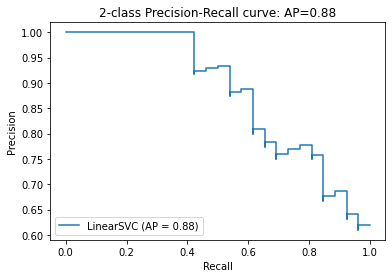

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#### For multiple labels

Creating data

In [22]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=random_state)

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

Calculate the average precision score in multi-label settings

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.40


Plot the Precision-Recall curve over all classes

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.40')

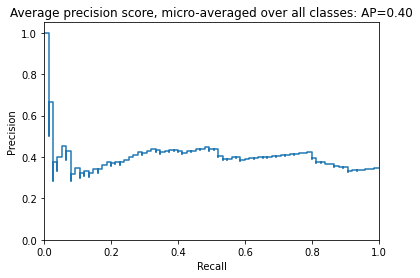

In [24]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

Plot the Precision-Recall curve for all labels individually as well as the F1 curves

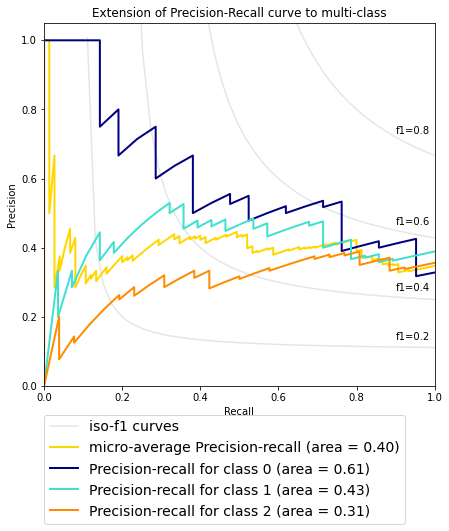

In [25]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

## Conclusion
Precision and Recall are two big metrics to analyze the performance of our models. Albeit it might be important to maximize either for specific cases, using the F1-score can be a balanced way to maximize both metrics.